In [205]:
import pandas as pd
import os
import pickle
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [224]:
model2 = 'DEFINITIVO_2_mask_Xception_fine-04_batch-8_lr-0001_auc-99'
model1 = 'DEFINITIVO_1_05_Xception_fine-05_batch-8_lr-0001_auc-99'
# model = 'completo_mask_Xception_fine-03_batch-8_lr-0001_auc-99'

In [225]:
direc1 = os.path.join('/home/mr1142/Documents/Data/heatmaps', model1)
direc2 = os.path.join('/home/mr1142/Documents/Data/heatmaps', model2)

In [226]:
with open(os.path.join(direc1, "proportions"), "rb") as fp:
    prop1 = pickle.load(fp)
with open(os.path.join(direc2, "proportions"), "rb") as fp:
    prop2 = pickle.load(fp)

In [227]:
images1 = os.listdir(direc1)
images2 = os.listdir(direc2)

Text(0.5, 1.0, 'Mask model')

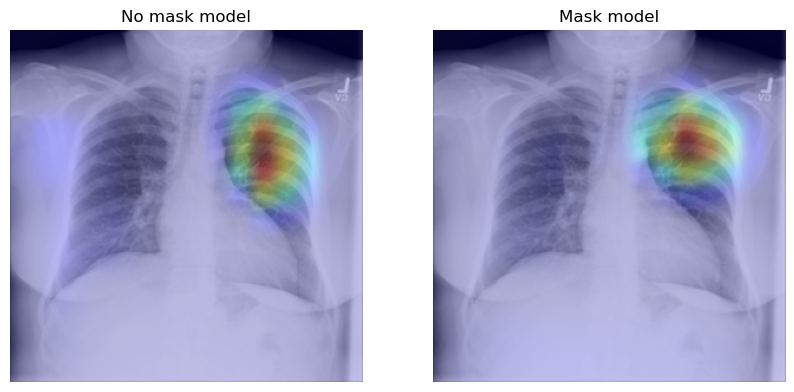

In [248]:
i = np.random.randint(0,len(images))
image = images1[i]
fig, ax = plt.subplots(1,2, figsize=(10,10))
ax[0].imshow(cv2.imread(os.path.join(direc1, image)))
ax[0].axis('off')
ax[0].set_title('No mask model')
ax[1].imshow(cv2.imread(os.path.join(direc2, image)))
ax[1].axis('off')
ax[1].set_title('Mask model')

# Imagenes con predicciones

In [300]:
os.environ['CUDA_VISIBLE_DEVICES'] = str(0)
from tensorflow import keras
import tensorflow as tf
from skimage import measure
from scipy import ndimage

In [250]:
path = '/home/mr1142/Documents/Data/models/neumonia'
model1 = keras.models.load_model(os.path.join(path, model1 + '.h5'))
model2 = keras.models.load_model(os.path.join(path, model2 + '.h5'))

2022-10-30 11:45:26.390496: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-30 11:45:32.294575: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10402 MB memory:  -> device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:05:00.0, compute capability: 6.1


In [301]:
def recolor_resize(img, pix=256):
    try:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    except:
        print('', end = '')
    img = cv2.resize(img, (pix, pix))
    img = np.expand_dims(img, axis=-1)
    return img


def recolor(img):
    try:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    except:
        print('', end = '')
    return img


def normalize(img):
    return (img - np.mean(img))/ np.std(img)


def quitar_trozos(mask):
    mask = measure.label(mask)
    ntotal = {k: (k==mask).sum() for k in np.unique(mask) if k >0}
    k = list(ntotal.keys())[np.argmax(list(ntotal.values()))]
    mask = k==mask
    mask = ndimage.binary_fill_holes(mask, structure=np.ones((5,5)))
    return mask


def des_normalize(img):
    return cv2.normalize(img, None, alpha = 0, beta = 255,
                         norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_16UC1)


def apply_mask(img, model):
    pix1 = img.shape[0]
    pix2 = img.shape[1]
    # Paso la imagen a escala de grises
    img = recolor(img)
    # Creo una nueva imagen con las dimensiones de entrada al modelo
    img_2 = normalize(recolor_resize(img, 256))[np.newaxis,...]
    # Genero la mascara
    mask = model.predict(img_2, verbose = 0)[0,...]
    # Escalo la mascara generada al tamaño de la imagen de entrada
    mask = cv2.resize(mask, (pix2, pix1))
    # Limpio la mascara
    mask = quitar_trozos(mask > 0.5)
    return img*mask


model_mask = os.path.join('/home/mr1142/Documents/Data/models/mascaras/unet_final_renacimiento_validation_6.h5')
model_mask = keras.models.load_model(model_mask, 
                                    custom_objects={"loss_mask": tf.keras.losses.BinaryCrossentropy, 
                                                    "dice_coef_loss": tf.keras.losses.BinaryCrossentropy,
                                                    "dice_coef": tf.keras.losses.BinaryCrossentropy})


def equalize(img, clip_limit=0.01, med_filt=5,output_type='uint16', flag_draw=False,):
    if img.dtype is np.dtype(np.float32):
        img_norm = img / img.max()                                    # Format adaptation
    else:
        img_norm = img.astype('float32') / np.iinfo(img.dtype).max                  # Format adaptation
    img_clahe = exposure.equalize_adapthist(img_norm, clip_limit=clip_limit)        # CLAHE
    img_clahe_median = filters.median(img_clahe,np.ones((3,3,1))).astype('float32')   # Median Filter

    lower, upper = np.percentile(img_clahe_median.flatten(), [2, 98])
    img_clip = np.clip(img_clahe_median,lower, upper)
    img_out = (img_clip - lower)/(upper - lower)

    if output_type is not None:
        max_val=np.iinfo(output_type).max
        img_out=(max_val*img_out).astype(output_type)
    else:
        max_val=1.0
    return img_out


def clahe(img):
    clahe = cv2.createCLAHE(clipLimit = 2)
    img = np.uint8(img)
    final_img = clahe.apply(img)
    final_img = np.expand_dims(final_img, axis=-1)
    return final_img


def get_prepared_img(img, pix, mask = False, clahe_bool = True, equalize_bool = False):
    if equalize_bool:
        img = equalize(img)
    if mask:
        img = des_normalize(apply_mask(img, model_mask))
    img = recolor_resize(img, pix)
    if clahe_bool:
        img = clahe(img)
    img = normalize(img)
    return img

In [290]:
def predict(model, image, mask):
    image = cv2.imread(os.path.join('/home/mr1142/Documents/Data/global_pneumonia_selection/test', image))
    image = np.expand_dims(get_prepared_img(image, 512, mask = mask), axis = 0)
    pneumonia_prob = 1-model.predict(image, verbose = 0)[0][0]
    return 'Pneumonia probability: ' + str(round(pneumonia_prob*100,2)) + '%'

In [291]:
predict(model1, images[i], False)

'Pneumonia probability: 69.1%'

Normal-8299.png


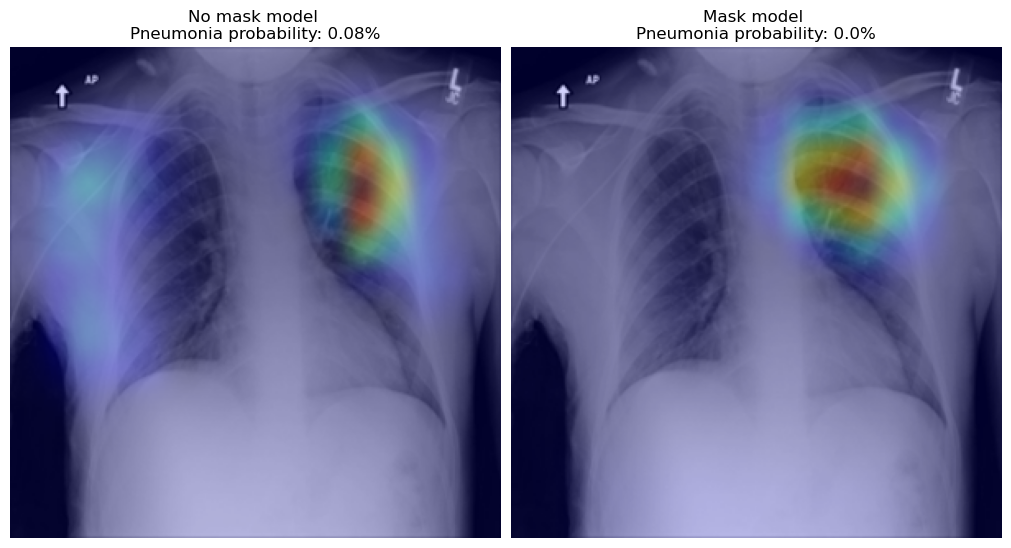

In [515]:
i = np.random.randint(0,len(images))
image = images1[i]
fig, ax = plt.subplots(1,2, figsize=(10,10), constrained_layout=True)
ax[0].imshow(cv2.imread(os.path.join(direc1, image)))
ax[0].axis('off')
ax[0].set_title('No mask model \n' + predict(model1, image, False))
ax[1].imshow(cv2.imread(os.path.join(direc2, image)))
ax[1].axis('off')
ax[1].set_title('Mask model \n' + predict(model2, image, True))
print(image)

In [500]:
fig.savefig('/home/mr1142/Documents/Data/heatmaps/' + image + '.png')